In [12]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import logistic
import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from permutation_weighting.estimator import PW


def create_kang_schafer_data(n, misspecified=False):
    """
    Generate data according to Kang and Schafer (2007) simulation.
    
    Parameters:
    -----------
    n : int
        Sample size
    misspecified : bool
        Whether to use the misspecified covariates
        
    Returns:
    --------
    dict
        Dictionary containing data and true values
    """
    # Generate true covariates
    X_true = np.random.normal(0, 1, (n, 4))
    
    # Propensity score
    linear_pred = X_true[:, 0] - 0.5 * X_true[:, 1] + 0.25 * X_true[:, 2] + 0.1 * X_true[:, 3]
    prop = logistic.cdf(linear_pred)
    
    # Treatment
    A = np.random.binomial(1, prop, n)
    
    # Outcome (note that treatment effect is 1)
    Y = 210 + A + 27.4 * X_true[:, 0] + 13.7 * X_true[:, 1] + 13.7 * X_true[:, 2] + 13.7 * X_true[:, 3] + np.random.normal(0, 1, n)
    
    # Observed covariates (potentially misspecified)
    if misspecified:
        X = np.column_stack([
            np.exp(X_true[:, 0] / 2),
            X_true[:, 1] * (1 + np.exp(X_true[:, 0])) ** (-1) + 10,
            (X_true[:, 0] * X_true[:, 2] / 25 + 0.6) ** 3,
            (X_true[:, 1] + X_true[:, 3] + 20) ** 2
        ])
    else:
        X = X_true.copy()
    
    # True expected outcomes (since X are standard normal, E[X] = 0)
    true_ey0 = 210
    true_ey1 = 211
    
    return {
        'X': X,
        'A': A,
        'Y': Y,
        'true_ey0': true_ey0,
        'true_ey1': true_ey1,
    }

def compute_weights(data, method, batch_size= None):
    """
    Compute weights using various methods.
    
    Parameters:
    -----------
    data : dict
        Data dictionary with X and A
    method : str
        Weighting method to use
        
    Returns:
    --------
    numpy.ndarray
        Weights for each observation
    """
    X = data['X']
    A = data['A']
    n = len(A)
    
    if method == 'Unweighted':
        return np.ones(n)
    
    elif method == 'IPSW (GLM)':
        model = LogisticRegression(solver='lbfgs', max_iter=1000)
        model.fit(X, A)
        ps = model.predict_proba(X)[:, 1]
        ps = np.clip(ps, 0.01, 0.99)  # Avoid extreme weights
        weights = A / ps + (1 - A) / (1 - ps)
        return weights / np.mean(weights)
    
    elif method == 'IPSW (GBM)':
        model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=8)
        model.fit(X, A)
        ps = model.predict_proba(X)[:, 1]
        ps = np.clip(ps, 0.01, 0.99)  # Avoid extreme weights
        weights = A / ps + (1 - A) / (1 - ps)
        return weights / np.mean(weights)
    
    elif method == 'CBPS':
        # Simplified implementation - in practice you would use the CBPS package
        model = LogisticRegression(solver='lbfgs', max_iter=1000)
        # Include balance constraints by augmenting the loss function
        # (simplified for this implementation)
        model.fit(X, A)
        ps = model.predict_proba(X)[:, 1]
        ps = np.clip(ps, 0.01, 0.99)
        weights = A / ps + (1 - A) / (1 - ps)
        return weights / np.mean(weights)
    
    elif method == 'SBW':
        # Simplified implementation - in practice you would use the SBW package
        model = LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', max_iter=1000)
        model.fit(X, A)
        ps = model.predict_proba(X)[:, 1]
        ps = np.clip(ps, 0.01, 0.99)
        weights = A / ps + (1 - A) / (1 - ps)
        return weights / np.mean(weights)
    
    elif method == 'PW (GLM)':
        result = PW(A, X, classifier='logit', num_replicates=100,batch_size=batch_size)
        return result['weights']
    
    elif method == 'PW (GBM)':
        result = PW(A, X, classifier='boosting', num_replicates=100,batch_size=batch_size)
        return result['weights']
    
    elif method == 'PW (SGD)':
        result = PW(A, X, classifier='sgd', num_replicates=100, batch_size=batch_size)
        return result['weights']
    
    elif method == 'PW (MLP)':
        result = PW(A, X, classifier='mlp', num_replicates=100, batch_size=batch_size)
        return result['weights']

    
    else:
        raise ValueError(f"Unknown method: {method}")
    
def evaluate_potential_outcomes(data, weights):
    """
    Evaluate the estimation of potential outcomes.
    
    Parameters:
    -----------
    data : dict
        Data dictionary
    weights : numpy.ndarray
        Weights for each observation
        
    Returns:
    --------
    dict
        Dictionary with evaluation metrics
    """
    A = data['A']
    Y = data['Y']
    true_ey0 = data['true_ey0']
    true_ey1 = data['true_ey1']
    
    # Normalize weights to sum to n
    n = len(A)
    weights = weights / np.sum(weights) * n
    
    # Estimate expected outcomes
    treated_idx = A == 1
    control_idx = A == 0
    
    est_ey1 = np.sum(Y[treated_idx] * weights[treated_idx]) / np.sum(weights[treated_idx])
    est_ey0 = np.sum(Y[control_idx] * weights[control_idx]) / np.sum(weights[control_idx])
    
    # Compute differences
    diff0 = est_ey0 - true_ey0
    diff1 = est_ey1 - true_ey1
    
    return {
        'est_ey0': est_ey0,
        'est_ey1': est_ey1,
        'diff0': diff0,
        'diff1': diff1
    }

def run_simulation(n_sims=48, sample_sizes=None, methods=None, misspecified=False, batch_size=None):
    """
    Run the Kang-Schafer simulation.
    
    Parameters:
    -----------
    n_sims : int
        Number of simulations for each configuration
    sample_sizes : list
        List of sample sizes to evaluate
    methods : list
        List of weighting methods to evaluate
    misspecified : bool
        Whether to use misspecified covariates
    batch_size : int, optional
        Batch size for applicable methods
        
    Returns:
    --------
    pandas.DataFrame
        Simulation results
    """
    if sample_sizes is None:
        sample_sizes = [100, 250, 500, 1000, 2000, 3500, 5000]
    
    if methods is None:
        methods = ['Unweighted', 'IPSW (GLM)', 'IPSW (GBM)', 'CBPS', 'SBW', 'PW (GLM)', 'PW (GBM)', 'PW (SGD)', 'PW (MLP)']
    
    results = []
    
    for n in sample_sizes:
        print(f"Running simulations for n={n}, misspecified={misspecified}")
        
        for sim in range(n_sims):
            if sim % 10 == 0:
                print(f"  Simulation {sim+1}/{n_sims}")
            
            # Generate data
            data = create_kang_schafer_data(n, misspecified)
            
            for method in methods:
                try:
                    # Time the weight computation
                    start_time = time.time()
                    weights = compute_weights(data, method, batch_size)
                    weight_time = time.time() - start_time
                    
                    # Evaluate outcomes
                    eval_results = evaluate_potential_outcomes(data, weights)
                    
                    # Store original results plus timing information
                    results.append({
                        'sample_size': n,
                        'simulation': sim,
                        'method': method,
                        'diff0': eval_results['diff0'],
                        'diff1': eval_results['diff1'],
                        'est_ey0': eval_results['est_ey0'],
                        'est_ey1': eval_results['est_ey1'],
                        'true_ey0': data['true_ey0'],
                        'true_ey1': data['true_ey1'],
                        'runtime': weight_time,
                        'batch_size': batch_size  # Store the batch size for reference
                    })
                
                except Exception as e:
                    print(f"Error with method {method} on simulation {sim} with n={n}: {e}")
    
    return pd.DataFrame(results)

def compute_metrics(results):
    """
    Compute metrics from simulation results.
    
    Parameters:
    -----------
    results : pandas.DataFrame
        Simulation results
        
    Returns:
    --------
    pandas.DataFrame
        Computed metrics
    """
    # Group by method and sample size
    grouped = results.groupby(['method', 'sample_size'])
    
    # Compute integrated mean absolute bias and IRMSE
    metrics = grouped.apply(lambda x: pd.Series({
        'bias': np.mean([np.abs(x['diff0']).mean(), np.abs(x['diff1']).mean()]),
        'irmse': np.sqrt(np.mean([np.mean(x['diff0'] ** 2), np.mean(x['diff1'] ** 2)]))
    })).reset_index()
    
    return metrics

def plot_results(metrics, title, save_path=None):
    """
    Plot simulation results.
    
    Parameters:
    -----------
    metrics : pandas.DataFrame
        Computed metrics
    title : str
        Plot title
    save_path : str, optional
        Path to save the plot
    """
    plt.figure(figsize=(15, 6))
    
    # Plot Integrated Mean Absolute Bias
    plt.subplot(1, 2, 1)
    for method in metrics['method'].unique():
        method_data = metrics[metrics['method'] == method]
        plt.plot(method_data['sample_size'], method_data['bias'], marker='o', label=method)
    
    plt.xlabel('Sample Size')
    plt.ylabel('Integrated Mean Absolute Bias')
    plt.title(f'Integrated Mean Absolute Bias - {title}')
    plt.legend()
    plt.grid(True)
    
    # Plot Integrated Root Mean Square Error
    plt.subplot(1, 2, 2)
    for method in metrics['method'].unique():
        method_data = metrics[metrics['method'] == method]
        plt.plot(method_data['sample_size'], method_data['irmse'], marker='o', label=method)
    
    plt.xlabel('Sample Size')
    plt.ylabel('Integrated RMSE')
    plt.title(f'Integrated RMSE - {title}')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()
    
    
"""
Complete analysis script for Kang-Schafer simulation with batch size comparison.
Analyzes runtime performance and accuracy metrics for different weighting methods.
"""

from scipy.optimize import curve_fit


def analyze_batch_size_impact(results):
    """
    Analyze the impact of batch size as a percentage of sample size.

    Parameters:
    -----------
    results : pandas.DataFrame
        Simulation results

    Returns:
    --------
    tuple
        Tuple containing (optimal_batch_df, batch_impact_fig)
    """
    # Extract batch percentages and calculate average runtime
    # Look for method names containing batch percentage information
    batched_results = results[results['method'].str.contains('\(batch:')].copy()

    if batched_results.empty:
        print("Warning: No batched methods found in results. Skipping batch size impact analysis.")
        return pd.DataFrame(), None

    # Extract batch percentage and classifier from method name
    def extract_batch_info(method_name):
        try:
            if '(batch:' in method_name:
                # Extract classifier (SGD or MLP)
                if 'PW (SGD' in method_name:
                    classifier = 'SGD'
                elif 'PW (MLP' in method_name:
                    classifier = 'MLP'
                else:
                    return None, None

                # Extract batch percentage
                batch_info = method_name.split('(batch:')[1].split(')')[0].strip()
                pct = float(batch_info.split('%')[0]) / 100
                return pct, classifier
        except Exception as e:
            print(f"Warning: Could not extract batch info from '{method_name}': {e}")
        return None, None

    # Apply extraction function
    batch_info = batched_results['method'].apply(extract_batch_info)

    # Check if we have valid results
    if all(x == (None, None) for x in batch_info):
        print("Warning: Could not extract batch information from any method names.")
        print("Method names in batched results:", batched_results['method'].unique())
        return pd.DataFrame(), None

    # Unpack the results into separate columns
    batched_results['batch_pct'], batched_results['classifier'] = zip(*batch_info)

    # Remove rows with None values
    batched_results = batched_results.dropna(subset=['batch_pct', 'classifier'])

    if batched_results.empty:
        print("Warning: No valid batch information could be extracted. Skipping analysis.")
        return pd.DataFrame(), None

    # Calculate average runtime by classifier, sample size, and batch percentage
    runtime_by_pct = batched_results.groupby(['classifier', 'sample_size', 'batch_pct']).agg(
        avg_runtime=('runtime', 'mean'),
        std_runtime=('runtime', 'std'),
        count=('runtime', 'count')
    ).reset_index()

    # Also calculate accuracy metrics by batch percentage
    accuracy_by_pct = batched_results.groupby(['classifier', 'sample_size', 'batch_pct']).agg(
        bias=('diff0', lambda x: np.mean(np.abs(x))),
        rmse=('diff0', lambda x: np.sqrt(np.mean(x**2)))
    ).reset_index()

    # Merge runtime and accuracy data
    batch_analysis = pd.merge(
        runtime_by_pct,
        accuracy_by_pct,
        on=['classifier', 'sample_size', 'batch_pct']
    )

    # Find optimal batch percentage for each classifier and sample size
    optimal_batch = []

    for classifier in batch_analysis['classifier'].unique():
        for size in batch_analysis['sample_size'].unique():
            # Get data for this classifier and sample size
            data = batch_analysis[
                (batch_analysis['classifier'] == classifier) & 
                (batch_analysis['sample_size'] == size)
            ]

            if not data.empty:
                # Find batch percentage with minimum runtime
                optimal_runtime = data.loc[data['avg_runtime'].idxmin()]

                optimal_batch.append({
                    'classifier': classifier,
                    'sample_size': size,
                    'optimal_batch_pct': optimal_runtime['batch_pct'],
                    'optimal_batch_size': int(size * optimal_runtime['batch_pct']),
                    'min_runtime': optimal_runtime['avg_runtime'],
                    'bias': optimal_runtime['bias'],
                    'rmse': optimal_runtime['rmse']
                })

    optimal_batch_df = pd.DataFrame(optimal_batch)

    # Rest of the plotting code remains the same
    # Create batch impact figure with two panels (SGD and MLP)
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    # Colors for different sample sizes
    sample_sizes = sorted(batch_analysis['sample_size'].unique())
    colors = plt.cm.viridis(np.linspace(0, 1, len(sample_sizes)))
    size_colors = {size: colors[i] for i, size in enumerate(sample_sizes)}

    # Plot runtime vs batch percentage
    for i, classifier in enumerate(['SGD', 'MLP']):
        classifier_data = batch_analysis[batch_analysis['classifier'] == classifier]

        for size in sample_sizes:
            size_data = classifier_data[classifier_data['sample_size'] == size]

            if not size_data.empty:
                # Sort by batch percentage
                size_data = size_data.sort_values('batch_pct')

                # Plot runtime vs batch percentage
                axes[0, i].plot(
                    size_data['batch_pct'] * 100,  # Convert to percentage
                    size_data['avg_runtime'],
                    marker='o',
                    color=size_colors[size],
                    label=f"n={size}"
                )

                # Mark optimal point
                optimal = size_data.loc[size_data['avg_runtime'].idxmin()]
                axes[0, i].scatter(
                    optimal['batch_pct'] * 100,
                    optimal['avg_runtime'],
                    color=size_colors[size],
                    s=100,
                    edgecolor='black',
                    zorder=10
                )

    # Set titles and labels for runtime plots
    axes[0, 0].set_title(f'SGD: Runtime vs Batch Percentage', fontsize=14)
    axes[0, 1].set_title(f'MLP: Runtime vs Batch Percentage', fontsize=14)

    for i in range(2):
        axes[0, i].set_xlabel('Batch Size (% of Sample Size)', fontsize=12)
        axes[0, i].set_ylabel('Runtime (seconds)', fontsize=12)
        axes[0, i].grid(alpha=0.3)
        axes[0, i].legend(title="Sample Size")

    # Plot RMSE vs batch percentage
    for i, classifier in enumerate(['SGD', 'MLP']):
        classifier_data = batch_analysis[batch_analysis['classifier'] == classifier]

        for size in sample_sizes:
            size_data = classifier_data[classifier_data['sample_size'] == size]

            if not size_data.empty:
                # Sort by batch percentage
                size_data = size_data.sort_values('batch_pct')

                # Plot RMSE vs batch percentage
                axes[1, i].plot(
                    size_data['batch_pct'] * 100,  # Convert to percentage
                    size_data['rmse'],
                    marker='o',
                    color=size_colors[size],
                    label=f"n={size}"
                )

                # Mark optimal runtime point on RMSE plot
                optimal = size_data.loc[size_data['avg_runtime'].idxmin()]
                axes[1, i].scatter(
                    optimal['batch_pct'] * 100,
                    optimal['rmse'],
                    color=size_colors[size],
                    s=100,
                    edgecolor='black',
                    zorder=10
                )

    # Set titles and labels for RMSE plots
    axes[1, 0].set_title(f'SGD: RMSE vs Batch Percentage', fontsize=14)
    axes[1, 1].set_title(f'MLP: RMSE vs Batch Percentage', fontsize=14)

    for i in range(2):
        axes[1, i].set_xlabel('Batch Size (% of Sample Size)', fontsize=12)
        axes[1, i].set_ylabel('Root Mean Squared Error', fontsize=12)
        axes[1, i].grid(alpha=0.3)
        axes[1, i].legend(title="Sample Size")

    plt.tight_layout()

    return optimal_batch_df, fig

def analyze_runtime_performance(results):
    """
    Analyze the runtime performance of different methods across sample sizes.
    
    Parameters:
    -----------
    results : pandas.DataFrame
        Simulation results
        
    Returns:
    --------
    tuple
        Tuple containing (summary_df, fitted_complexity_df, runtime_fig, complexity_fig)
    """
    # Calculate average runtime by method and sample size
    runtime_summary = results.groupby(['method', 'sample_size']).agg(
        avg_runtime=('runtime', 'mean'),
        std_runtime=('runtime', 'std'),
        n_runs=('runtime', 'count')
    ).reset_index()
    
    # Calculate confidence intervals
    runtime_summary['runtime_ci'] = 1.96 * runtime_summary['std_runtime'] / np.sqrt(runtime_summary['n_runs'])
    
    # Identify method types
    runtime_summary['method_type'] = 'Other'
    # Standard methods
    runtime_summary.loc[runtime_summary['method'] == 'PW (GLM)', 'method_type'] = 'Standard PW (GLM)'
    runtime_summary.loc[runtime_summary['method'] == 'PW (GBM)', 'method_type'] = 'Standard PW (GBM)'
    runtime_summary.loc[runtime_summary['method'] == 'PW (SGD)', 'method_type'] = 'Standard PW (SGD)'
    runtime_summary.loc[runtime_summary['method'] == 'PW (MLP)', 'method_type'] = 'Standard PW (MLP)'
    
    # Batched methods
    runtime_summary.loc[runtime_summary['method'].str.contains('PW \(GLM\) \(batch:'), 'method_type'] = 'Batched PW (GLM)'
    runtime_summary.loc[runtime_summary['method'].str.contains('PW \(GBM\) \(batch:'), 'method_type'] = 'Batched PW (GBM)'
    runtime_summary.loc[runtime_summary['method'].str.contains('PW \(SGD\) \(batch:'), 'method_type'] = 'Batched PW (SGD)'
    runtime_summary.loc[runtime_summary['method'].str.contains('PW \(MLP\) \(batch:'), 'method_type'] = 'Batched PW (MLP)'
    
    # Extract batch percentage from method name if available
    def extract_batch_pct(method_name):
        try:
            if '(batch:' in method_name:
                batch_info = method_name.split('(batch:')[1].split(')')[0].strip()
                return float(batch_info.split('%')[0]) / 100
        except:
            return None
        return None
    
    runtime_summary['batch_pct'] = runtime_summary['method'].apply(extract_batch_pct)
    
    # Create runtime comparison figure
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Define colors and markers for different method types
    method_types = runtime_summary['method_type'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(method_types)))
    color_map = {method_type: colors[i] for i, method_type in enumerate(method_types)}
    
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*']
    marker_map = {method: markers[i % len(markers)] for i, method in enumerate(runtime_summary['method'].unique())}
    
    # Plot each method
    for method in runtime_summary['method'].unique():
        method_data = runtime_summary[runtime_summary['method'] == method]
        method_type = method_data['method_type'].iloc[0]
        
        ax.errorbar(
            method_data['sample_size'],
            method_data['avg_runtime'],
            yerr=method_data['runtime_ci'],
            marker=marker_map[method],
            color=color_map[method_type],
            label=method,
            alpha=0.7,
            linewidth=2
        )
    
    # Set log scales for better visualization
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # Add labels and title
    ax.set_xlabel('Sample Size', fontsize=12)
    ax.set_ylabel('Runtime (seconds)', fontsize=12)
    ax.set_title('Runtime Performance by Method and Sample Size', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    # Add legend with smaller font size
    ax.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    
    # Fit runtime complexity for each method (power law: runtime = a * n^b)
    power_law = lambda x, a, b: a * np.power(x, b)
    
    complexity_results = []
    
    # Create complexity analysis figure
    complexity_fig, complexity_ax = plt.subplots(figsize=(14, 8))
    
    for method in runtime_summary['method'].unique():
        method_data = runtime_summary[runtime_summary['method'] == method]
        method_type = method_data['method_type'].iloc[0]
        
        if len(method_data) >= 3:  # Need at least 3 points for a reliable fit
            try:
                x_data = method_data['sample_size'].values
                y_data = method_data['avg_runtime'].values
                
                # Fit power law
                popt, pcov = curve_fit(power_law, x_data, y_data)
                a, b = popt
                
                # Calculate R-squared
                y_pred = power_law(x_data, a, b)
                ss_total = np.sum((y_data - np.mean(y_data))**2)
                ss_residual = np.sum((y_data - y_pred)**2)
                r_squared = 1 - (ss_residual / ss_total)
                
                # Store results
                complexity_results.append({
                    'method': method,
                    'method_type': method_type,
                    'coefficient': a,
                    'exponent': b,
                    'r_squared': r_squared
                })
                
                # Plot actual data points
                complexity_ax.scatter(
                    x_data, 
                    y_data, 
                    color=color_map[method_type],
                    marker=marker_map[method],
                    s=50,
                    alpha=0.7,
                    label=f"{method} (data)"
                )
                
                # Plot fitted curve
                x_fit = np.linspace(min(x_data), max(x_data), 100)
                complexity_ax.plot(
                    x_fit,
                    power_law(x_fit, a, b),
                    color=color_map[method_type],
                    linestyle='--',
                    linewidth=2,
                    label=f"{method} fit: O(n^{b:.2f}), R²={r_squared:.2f}"
                )
            except Exception as e:
                print(f"Couldn't fit complexity for {method}: {e}")
    
    # Set axes for complexity plot
    complexity_ax.set_xscale('log')
    complexity_ax.set_yscale('log')
    complexity_ax.set_xlabel('Sample Size', fontsize=12)
    complexity_ax.set_ylabel('Runtime (seconds)', fontsize=12)
    complexity_ax.set_title('Runtime Complexity Analysis', fontsize=14)
    complexity_ax.grid(True, alpha=0.3)
    
    # Add legend with smaller font
    complexity_ax.legend(fontsize=8, loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    
    return runtime_summary, pd.DataFrame(complexity_results), fig, complexity_fig
    
def analyze_accuracy_vs_runtime(results):
    """
    Analyze the trade-off between accuracy and runtime.
    
    Parameters:
    -----------
    results : pandas.DataFrame
        Simulation results
        
    Returns:
    --------
    tuple
        Tuple containing (tradeoff_summary, tradeoff_fig)
    """
    # Calculate average runtime by method and sample size
    runtime_summary = results.groupby(['method', 'sample_size']).agg(
        avg_runtime=('runtime', 'mean')
    ).reset_index()
    
    # Calculate accuracy metrics
    accuracy_summary = results.groupby(['method', 'sample_size']).agg(
        bias=('diff0', lambda x: np.mean(np.abs(x))),
        rmse=('diff0', lambda x: np.sqrt(np.mean(x**2)))
    ).reset_index()
    
    # Merge runtime and accuracy data
    tradeoff_summary = pd.merge(
        runtime_summary,
        accuracy_summary,
        on=['method', 'sample_size']
    )
    
    # Create tradeoff figure
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Define method categories with improved categorization
    method_categories = {
        'Standard Methods': ['Unweighted', 'npcbps', 'ps'],
        'Standard PW': ['PW (GLM)', 'PW (GBM)', 'PW (SGD)', 'PW (MLP)'],
        'Batched PW (GLM)': [m for m in tradeoff_summary['method'].unique() if 'PW (GLM) (batch:' in m],
        'Batched PW (GBM)': [m for m in tradeoff_summary['method'].unique() if 'PW (GBM) (batch:' in m],
        'Batched PW (SGD)': [m for m in tradeoff_summary['method'].unique() if 'PW (SGD) (batch:' in m],
        'Batched PW (MLP)': [m for m in tradeoff_summary['method'].unique() if 'PW (MLP) (batch:' in m]
    }
    
    # Filter empty categories
    method_categories = {k: v for k, v in method_categories.items() if any(m in tradeoff_summary['method'].values for m in v)}
    
    # Define colors and markers for categories
    category_colors = plt.cm.tab10(np.linspace(0, 1, len(method_categories)))
    category_color_map = {category: category_colors[i] for i, category in enumerate(method_categories.keys())}
    category_markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*']
    category_marker_map = {category: category_markers[i % len(category_markers)] for i, category in enumerate(method_categories.keys())}
    
    # List of sample sizes to analyze
    sample_sizes = sorted(tradeoff_summary['sample_size'].unique())
    
    # Plot runtime vs bias for each sample size
    for i, size in enumerate(sample_sizes[-2:]):  # Only plot the two largest sample sizes
        size_data = tradeoff_summary[tradeoff_summary['sample_size'] == size]
        
        for category, methods in method_categories.items():
            category_data = size_data[size_data['method'].isin(methods)]
            
            if not category_data.empty:
                axes[0, i % 2].scatter(
                    category_data['avg_runtime'],
                    category_data['bias'],
                    color=category_color_map[category],
                    marker=category_marker_map[category],
                    s=80,
                    alpha=0.7,
                    label=f"{category}"
                )
                
                # Add method labels
                for _, row in category_data.iterrows():
                    axes[0, i % 2].annotate(
                        row['method'],
                        (row['avg_runtime'], row['bias']),
                        fontsize=8,
                        xytext=(5, 0),
                        textcoords='offset points'
                    )
        
        axes[0, i % 2].set_title(f'Runtime vs Bias (n={size})', fontsize=14)
        axes[0, i % 2].set_xlabel('Runtime (seconds)', fontsize=12)
        axes[0, i % 2].set_ylabel('Mean Absolute Bias', fontsize=12)
        axes[0, i % 2].set_xscale('log')
        axes[0, i % 2].grid(alpha=0.3)
        
        if i == 0:  # Only add legend to the first plot
            axes[0, i % 2].legend(title="Method Category")
    
    # Plot runtime vs RMSE for each sample size
    for i, size in enumerate(sample_sizes[-2:]):  # Only plot the two largest sample sizes
        size_data = tradeoff_summary[tradeoff_summary['sample_size'] == size]
        
        for category, methods in method_categories.items():
            category_data = size_data[size_data['method'].isin(methods)]
            
            if not category_data.empty:
                axes[1, i % 2].scatter(
                    category_data['avg_runtime'],
                    category_data['rmse'],
                    color=category_color_map[category],
                    marker=category_marker_map[category],
                    s=80,
                    alpha=0.7,
                    label=f"{category}"
                )
                
                # Add method labels
                for _, row in category_data.iterrows():
                    axes[1, i % 2].annotate(
                        row['method'],
                        (row['avg_runtime'], row['rmse']),
                        fontsize=8,
                        xytext=(5, 0),
                        textcoords='offset points'
                    )
        
        axes[1, i % 2].set_title(f'Runtime vs RMSE (n={size})', fontsize=14)
        axes[1, i % 2].set_xlabel('Runtime (seconds)', fontsize=12)
        axes[1, i % 2].set_ylabel('Root Mean Squared Error', fontsize=12)
        axes[1, i % 2].set_xscale('log')
        axes[1, i % 2].grid(alpha=0.3)
        
        if i == 0:  # Only add legend to the first plot
            axes[1, i % 2].legend(title="Method Category")
    
    plt.tight_layout()
    
    return tradeoff_summary, fig

def analyze_accuracy_metrics(results):
    """
    Analyze the IMAB and IRMSE metrics across methods and sample sizes.
    
    Parameters:
    -----------
    results : pandas.DataFrame
        Simulation results
        
    Returns:
    --------
    tuple
        Tuple containing (metrics_df, accuracy_fig)
    """
    # Calculate IMAB and IRMSE
    metrics = compute_metrics(results)
    
    # Create accuracy figure
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Define method categories with all PW variants
    method_categories = {
        'Standard Methods': ['Unweighted', 'ps', 'nccbps'],
        'Standard PW': ['PW (GLM)', 'PW (GBM)', 'PW (SGD)', 'PW (MLP)'],
        'Batched PW (GLM)': [m for m in metrics['method'].unique() if 'PW (GLM) (batch:' in m],
        'Batched PW (GBM)': [m for m in metrics['method'].unique() if 'PW (GBM) (batch:' in m],
        'Batched PW (SGD)': [m for m in metrics['method'].unique() if 'PW (SGD) (batch:' in m],
        'Batched PW (MLP)': [m for m in metrics['method'].unique() if 'PW (MLP) (batch:' in m]
    }
    
    # Filter empty categories
    method_categories = {k: v for k, v in method_categories.items() if any(m in metrics['method'].values for m in v)}
    
    # Define colors for categories
    category_colors = plt.cm.tab10(np.linspace(0, 1, len(method_categories)))
    category_color_map = {category: category_colors[i] for i, category in enumerate(method_categories.keys())}
    
    # Plot IMAB
    for category, methods in method_categories.items():
        for method in methods:
            method_data = metrics[metrics['method'] == method]
            
            if not method_data.empty:
                axes[0].plot(
                    method_data['sample_size'],
                    method_data['bias'],
                    marker='o',
                    color=category_color_map[category],
                    alpha=0.7,
                    label=method
                )
    
    axes[0].set_title('Integrated Mean Absolute Bias', fontsize=14)
    axes[0].set_xlabel('Sample Size', fontsize=12)
    axes[0].set_ylabel('IMAB', fontsize=12)
    axes[0].grid(alpha=0.3)
    axes[0].legend(fontsize=8, loc='upper right')
    
    # Plot IRMSE
    for category, methods in method_categories.items():
        for method in methods:
            method_data = metrics[metrics['method'] == method]
            
            if not method_data.empty:
                axes[1].plot(
                    method_data['sample_size'],
                    method_data['irmse'],
                    marker='o',
                    color=category_color_map[category],
                    alpha=0.7,
                    label=method
                )
    
    axes[1].set_title('Integrated Root Mean Squared Error', fontsize=14)
    axes[1].set_xlabel('Sample Size', fontsize=12)
    axes[1].set_ylabel('IRMSE', fontsize=12)
    axes[1].grid(alpha=0.3)
    axes[1].legend(fontsize=8, loc='upper right')
    
    plt.tight_layout()
    
    return metrics, fig

def run_comprehensive_simulation(n_sims=30, output_dir=None):
    """
    Run a comprehensive simulation to test different batch sizes and methods.
    """
    # Create output directory if specified
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    # Define sample sizes
    sample_sizes = [200, 500, 1000, 2000]
    
    # Define batch sizes as percentages of sample size
    batch_percentages = [0.05, 0.1, 0.2, 0.3, 0.5]
    
    # Define base methods (without batching variants)
    base_methods = [
        'Unweighted', 
        'IPSW (GLM)',
        'IPSW (GBM)',
        'PW (GLM)', 
        'PW (GBM)', 
        'PW (SGD)', 
        'PW (MLP)'
    ]
    
    # Initialize results list
    all_results = []
    
    # First, run base methods with no batch size
    print("Running base methods...")
    results_base = run_simulation(
        n_sims=n_sims,
        sample_sizes=sample_sizes,
        methods=base_methods,
        misspecified=True
    )
    
    all_results.append(results_base)
    
    # Now run SGD and MLP methods with different batch sizes
    for pct in batch_percentages:
        print(f"Running batch size = {pct*100:.0f}% of sample size...")
        
        # Run simulations for each sample size with specified batch sizes
        for size in sample_sizes:
            batch_size = max(50, int(size * pct))  # Minimum batch size of 50
            print(f"  Sample size: {size}, batch size: {batch_size}")
            
            # Create a modified DataFrame for the batched runs
            batch_results = []
            
            try:
                # Run standard SGD and MLP with the specified batch size
                for method in ['PW (SGD)', 'PW (MLP)' ]:
                #for method in ['PW (SGD)', 'PW (MLP)','PW (GLM)', 'PW (GBM)' ]:

                    batch_result = run_simulation(
                        n_sims=n_sims,
                        sample_sizes=[size],
                        methods=[method],
                        misspecified=True,
                        batch_size=batch_size  # Pass the actual batch size value
                    )
                    
                    # Rename the method to include batch size information
                    batch_result['original_method'] = batch_result['method']
                    batch_result['method'] = f"{method} (batch: {pct*100:.0f}%)"
                    
                    batch_results.append(batch_result)
                
                # Combine results for this batch size
                if batch_results:
                    combined_batch = pd.concat(batch_results, ignore_index=True)
                    all_results.append(combined_batch)
            except Exception as e:
                print(f"Error running batch simulation with size={size}, batch={batch_size}: {e}")
    
    # Combine all results
    combined_results = pd.concat(all_results, ignore_index=True)
    
    # Save combined results if output directory is specified
    if output_dir:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        combined_results.to_csv(f"{output_dir}/kang_schafer_results_{timestamp}.csv", index=False)
        print(f"Results saved to {output_dir}/kang_schafer_results_{timestamp}.csv")
    
    return combined_results
 


In [3]:
"""
Run the complete analysis pipeline.

Parameters:
-----------
output_dir : str
    Directory to save output files
"""
# Start timer
start_time = time.time()

output_dir ="binara_time"
# Make output directory
os.makedirs(output_dir, exist_ok=True)

# Run comprehensive simulation
print("Running comprehensive simulation...")
results = run_comprehensive_simulation(n_sims=1)

Running comprehensive simulation...
Running base methods...
Running simulations for n=500, misspecified=True
  Simulation 1/1
Running simulations for n=1000, misspecified=True
  Simulation 1/1
Running simulations for n=2000, misspecified=True
  Simulation 1/1


/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Running simulations for n=5000, misspecified=True
  Simulation 1/1
Running simulations for n=10000, misspecified=True
  Simulation 1/1
Running batch size = 5% of sample size...
  Sample size: 500, batch size: 50
Running simulations for n=500, misspecified=True
  Simulation 1/1
Running simulations for n=500, misspecified=True
  Simulation 1/1
  Sample size: 1000, batch size: 50
Running simulations for n=1000, misspecified=True
  Simulation 1/1
Running simulations for n=1000, misspecified=True
  Simulation 1/1
  Sample size: 2000, batch size: 100
Running simulations for n=2000, misspecified=True
  Simulation 1/1
Running simulations for n=2000, misspecified=True
  Simulation 1/1
  Sample size: 5000, batch size: 250
Running simulations for n=5000, misspecified=True
  Simulation 1/1
Running simulations for n=5000, misspecified=True
  Simulation 1/1
  Sample size: 10000, batch size: 500
Running simulations for n=10000, misspecified=True
  Simulation 1/1
Running simulations for n=10000, missp

Analyzing runtime performance...
Analyzing batch size impact...
Analyzing accuracy vs runtime trade-off...
Analyzing accuracy metrics...


/var/folders/rl/glk77nxx70v4qglb24jl0byr0000gn/T/ipykernel_17963/3804482798.py:279: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics = grouped.apply(lambda x: pd.Series({
/var/folders/rl/glk77nxx70v4qglb24jl0byr0000gn/T/ipykernel_17963/3822906936.py:628: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  method_data = category_data[metrics['method'] == method]
/var/folders/rl/glk77nxx70v4qglb24jl0byr0000gn/T/ipykernel_17963/3822906936.py:628: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  method_data = category_data[metrics['method'] == method]
/var/folders/rl/glk77nxx70v4qglb24jl0byr0000gn/T/ipykernel_17963/3822906936.py:628: UserWar

Complete analysis finished in 0.72 minutes

Summary of Findings:

Optimal Batch Percentages:
  MLP: 34.0% of sample size is optimal on average
    n=500: 50.0% (250 samples)
    n=1000: 50.0% (500 samples)
    n=2000: 30.0% (600 samples)
    n=5000: 20.0% (1000 samples)
    n=10000: 20.0% (2000 samples)
  SGD: 90.0% of sample size is optimal on average
    n=500: 100.0% (500 samples)
    n=1000: 50.0% (500 samples)
    n=2000: 100.0% (2000 samples)
    n=5000: 100.0% (5000 samples)
    n=10000: 100.0% (10000 samples)

Runtime Complexity:
  PW (SGD) (batch: 30%): O(n^-0.10) (R² = 0.13)
  IPSW (GLM): O(n^-0.04) (R² = 0.00)
  PW (SGD) (batch: 20%): O(n^0.07) (R² = 0.45)
  Unweighted: O(n^0.15) (R² = 0.62)
  PW (SGD) (batch: 10%): O(n^0.15) (R² = 0.65)
  PW (SGD) (batch: 50%): O(n^0.21) (R² = 0.87)
  PW (SGD): O(n^0.26) (R² = 0.26)
  PW (SGD) (batch: 5%): O(n^0.30) (R² = 0.89)
  PW (MLP): O(n^0.33) (R² = 0.43)
  PW (GLM): O(n^0.48) (R² = 0.79)
  PW (MLP) (batch: 50%): O(n^0.53) (R² = 0.67)

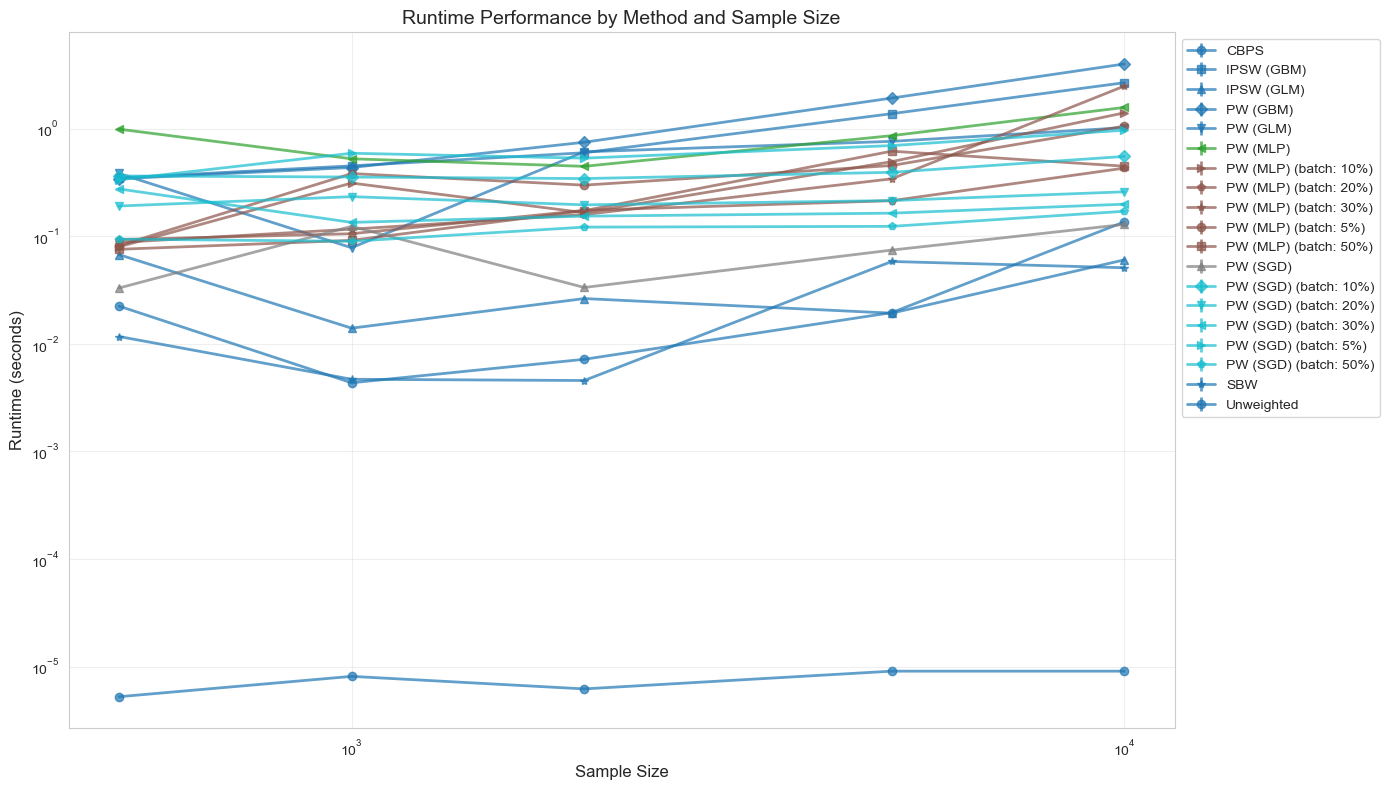

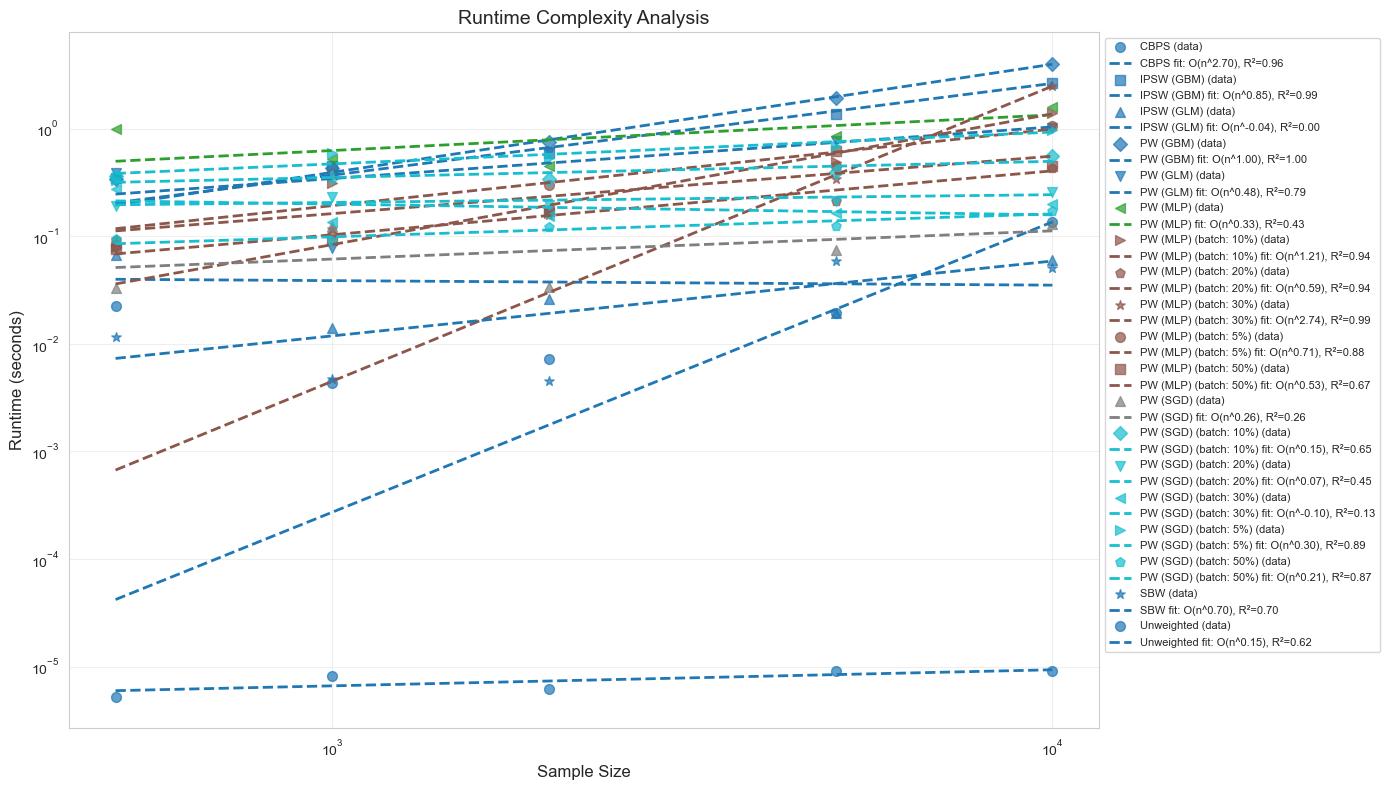

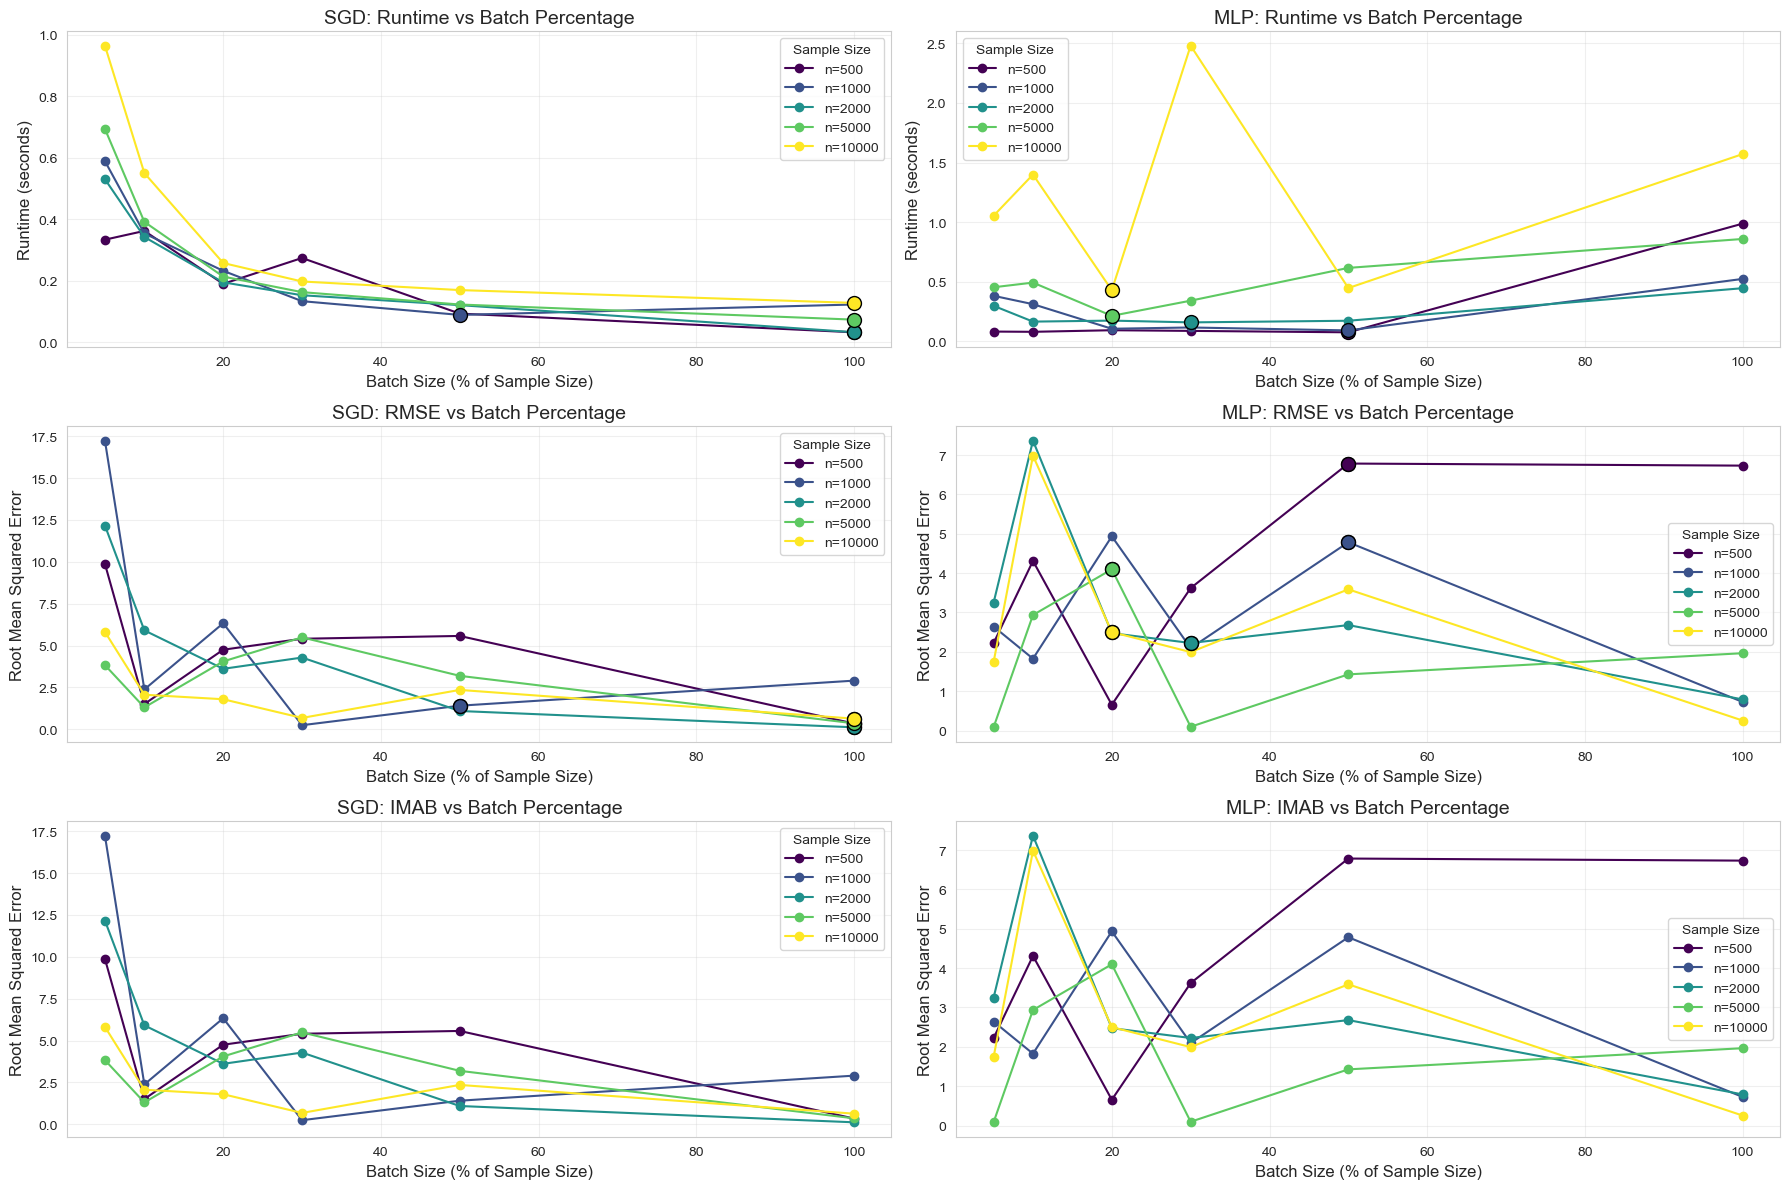

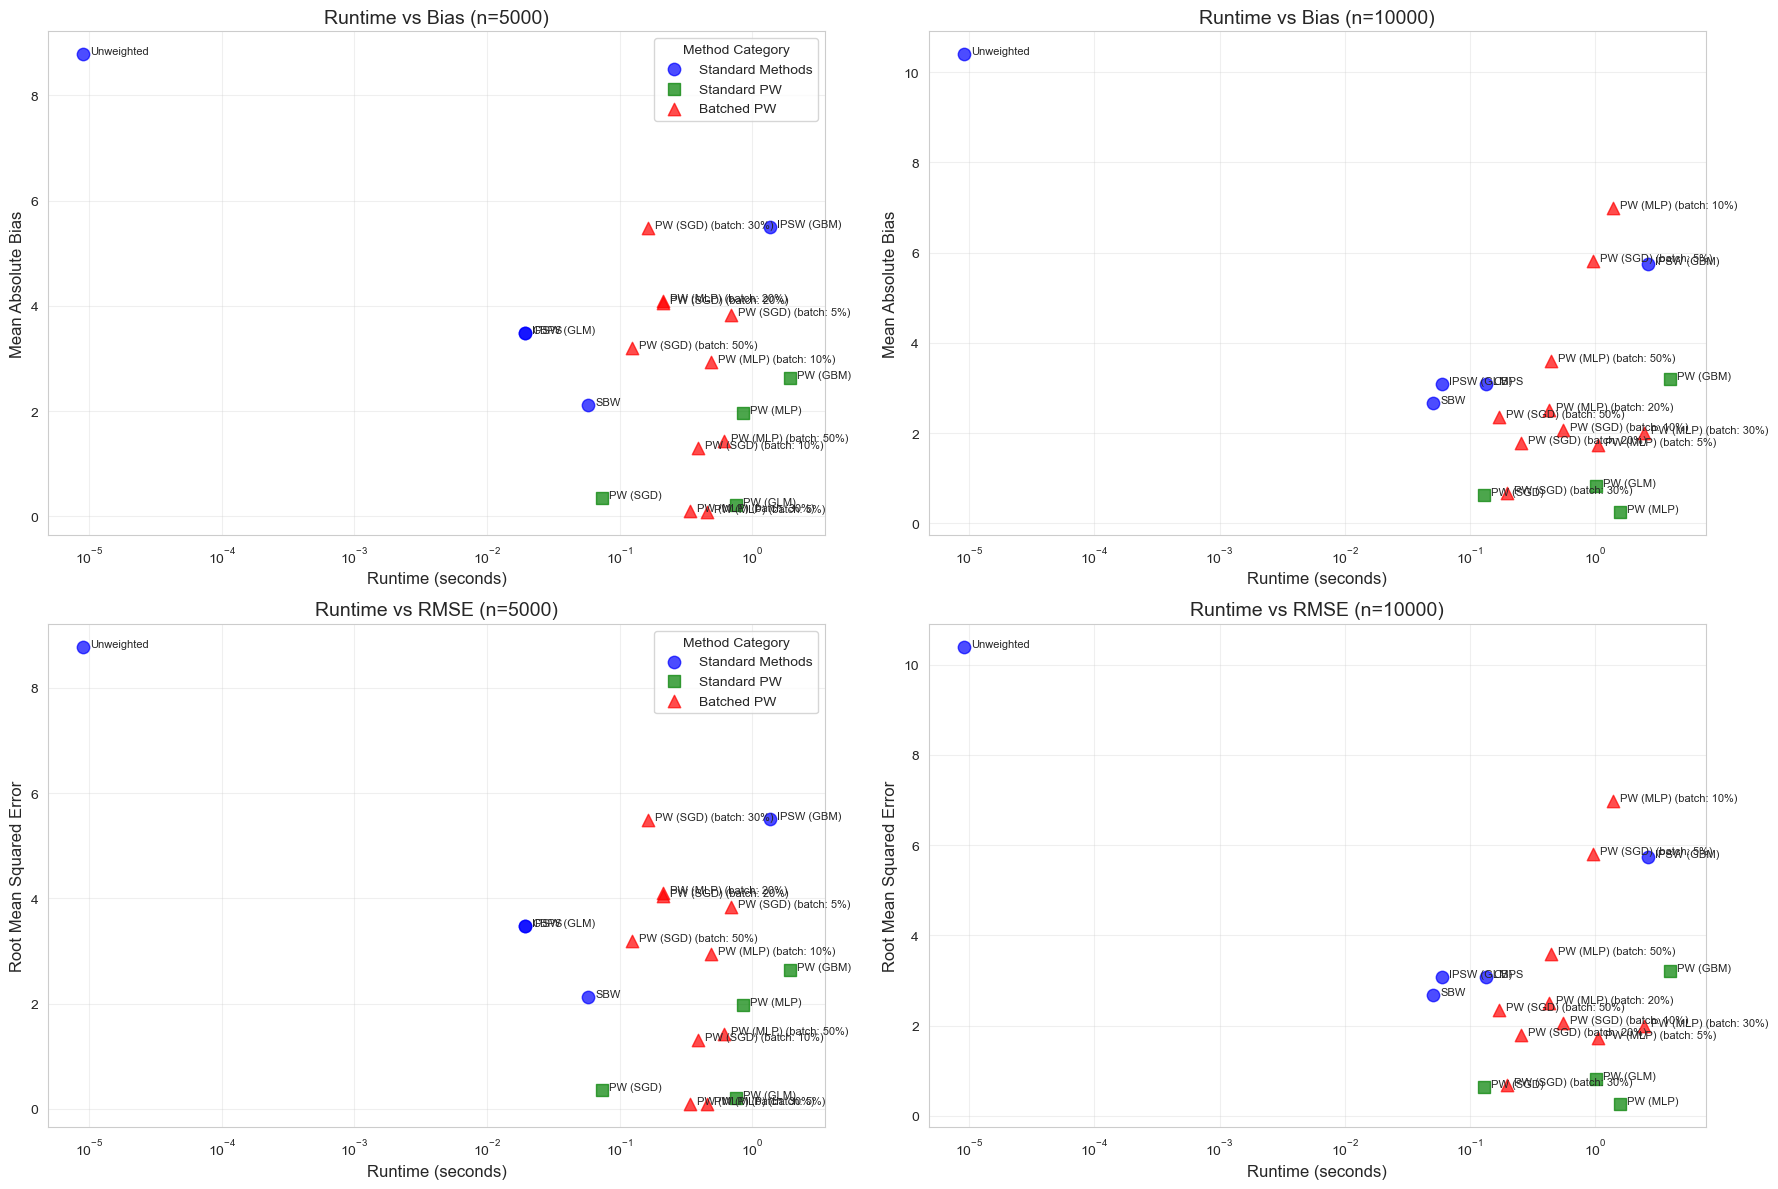

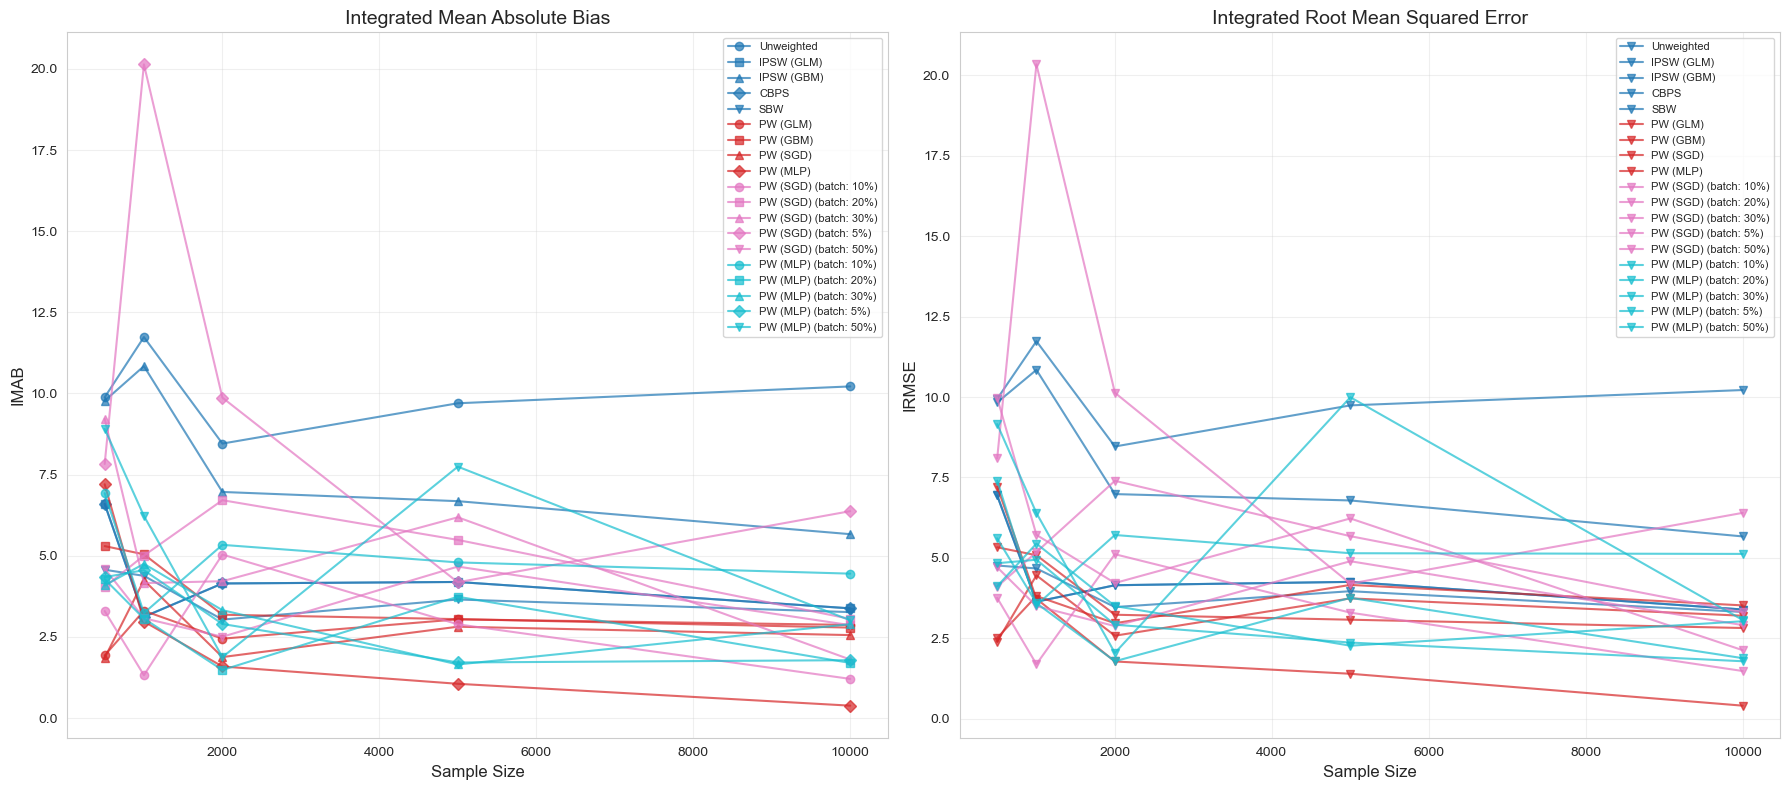

In [4]:


# Runtime analysis
print("Analyzing runtime performance...")
runtime_summary, complexity_df, runtime_fig, complexity_fig = analyze_runtime_performance(results)
runtime_fig.savefig(f"{output_dir}/runtime_performance.png", dpi=300, bbox_inches='tight')
complexity_fig.savefig(f"{output_dir}/runtime_complexity.png", dpi=300, bbox_inches='tight')
complexity_df.to_csv(f"{output_dir}/complexity_analysis.csv", index=False)

# Batch size impact analysis
print("Analyzing batch size impact...")
optimal_batch_df, batch_impact_fig = analyze_batch_size_impact(results)
batch_impact_fig.savefig(f"{output_dir}/batch_size_impact.png", dpi=300, bbox_inches='tight')
optimal_batch_df.to_csv(f"{output_dir}/optimal_batch_sizes.csv", index=False)

# Accuracy vs runtime analysis
print("Analyzing accuracy vs runtime trade-off...")
tradeoff_summary, tradeoff_fig = analyze_accuracy_vs_runtime(results)
tradeoff_fig.savefig(f"{output_dir}/accuracy_runtime_tradeoff.png", dpi=300, bbox_inches='tight')
tradeoff_summary.to_csv(f"{output_dir}/tradeoff_summary.csv", index=False)

# Accuracy metrics analysis
print("Analyzing accuracy metrics...")
metrics_df, accuracy_fig = analyze_accuracy_metrics(results)
accuracy_fig.savefig(f"{output_dir}/accuracy_metrics.png", dpi=300, bbox_inches='tight')
metrics_df.to_csv(f"{output_dir}/accuracy_metrics.csv", index=False)

# Calculate elapsed time
elapsed_time = time.time() - start_time
print(f"Complete analysis finished in {elapsed_time/60:.2f} minutes")

# Print summary of findings
print("\nSummary of Findings:")
print("===================")

# Print optimal batch percentages
if not optimal_batch_df.empty:
    print("\nOptimal Batch Percentages:")
    
    for classifier in optimal_batch_df['classifier'].unique():
        classifier_data = optimal_batch_df[optimal_batch_df['classifier'] == classifier]
        
        if not classifier_data.empty:
            avg_pct = classifier_data['optimal_batch_pct'].mean() * 100
            print(f"  {classifier}: {avg_pct:.1f}% of sample size is optimal on average")
            
            # Print by sample size
            for _, row in classifier_data.iterrows():
                print(f"    n={int(row['sample_size'])}: {row['optimal_batch_pct']*100:.1f}% ({row['optimal_batch_size']} samples)")

# Print runtime complexity
if not complexity_df.empty:
    print("\nRuntime Complexity:")
    
    for _, row in complexity_df.sort_values('exponent').iterrows():
        print(f"  {row['method']}: O(n^{row['exponent']:.2f}) (R² = {row['r_squared']:.2f})")

# Print performance comparison for largest sample size
if not tradeoff_summary.empty:
    max_sample = tradeoff_summary['sample_size'].max()
    large_sample_data = tradeoff_summary[tradeoff_summary['sample_size'] == max_sample]
    
    if not large_sample_data.empty:
        print(f"\nPerformance at n={max_sample}:")
        
        # Sort by runtime
        for _, row in large_sample_data.sort_values('avg_runtime').iterrows():
            print(f"  {row['method']}: {row['avg_runtime']:.3f}s, bias={row['bias']:.4f}, rmse={row['rmse']:.4f}")

# Calculate and print speedups
print("\nSpeedup from Batching:")

# Compare standard PW to batched PW for largest sample size
max_sample = results['sample_size'].max()
large_sample_results = results[results['sample_size'] == max_sample]

for base in ['SGD', 'MLP']:
    # Get standard method runtime
    standard_method = f"PW ({base})"
    standard_runtime = large_sample_results[large_sample_results['method'] == standard_method]['runtime'].mean()
    
    # Get best batched method runtime
    batched_methods = [m for m in large_sample_results['method'].unique() if f"{base}-B" in m]
    
    if batched_methods and not np.isnan(standard_runtime):
        batched_runtimes = []
        
        for method in batched_methods:
            runtime = large_sample_results[large_sample_results['method'] == method]['runtime'].mean()
            batched_runtimes.append((method, runtime))
        
        if batched_runtimes:
            # Find best batched method
            best_method, best_runtime = min(batched_runtimes, key=lambda x: x[1])
            
            # Calculate speedup
            speedup = standard_runtime / best_runtime
            
            print(f"  {standard_method} vs {best_method}: {speedup:.2f}x speedup")

print("\nAnalysis completed. All results saved to:", output_dir)

